The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [128]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro
import matplotlib.pyplot as plt


In [ ]:
# TODO : import the dataset

In [129]:
df = pd.read_csv('AB_Test_Results.csv', sep=',')

In [130]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [131]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [100]:
df.isnull().sum()

,0
USER_ID,0
VARIANT_NAME,0
REVENUE,0


In [101]:
df.nunique()

,0
USER_ID,6324
VARIANT_NAME,2
REVENUE,101


In [132]:
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
print(double_variant_count)

VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64


In [ ]:
# TODO : take a quick look at the data

In [133]:
# Calculate the total number of users
total_users = df['USER_ID'].nunique()
print(f"Total number of users in the dataset : {total_users}")

Total number of users in the dataset : 6324


**Let**'s see if there are users who have two A/B test groups

In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user


In [134]:
# Calculate the number of unique groups ('VARIANT_NAME') for each user ('USER_ID')
unique_groups_per_user = df.groupby('USER_ID')['VARIANT_NAME'].nunique()

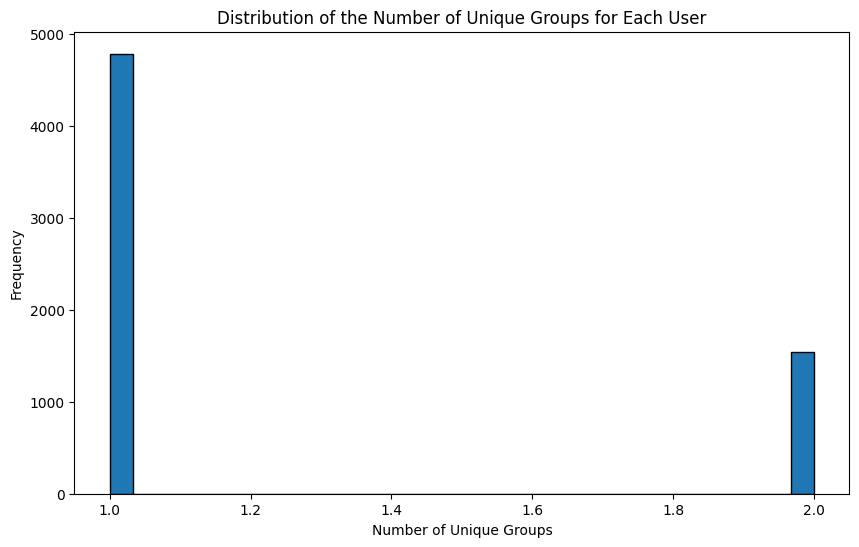

In [135]:
# Visualize the distribution of the number of unique groups per user
plt.figure(figsize=(10,6))
plt.hist(unique_groups_per_user, bins=30, edgecolor='black')
plt.title('Distribution of the Number of Unique Groups for Each User')
plt.xlabel('Number of Unique Groups')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms


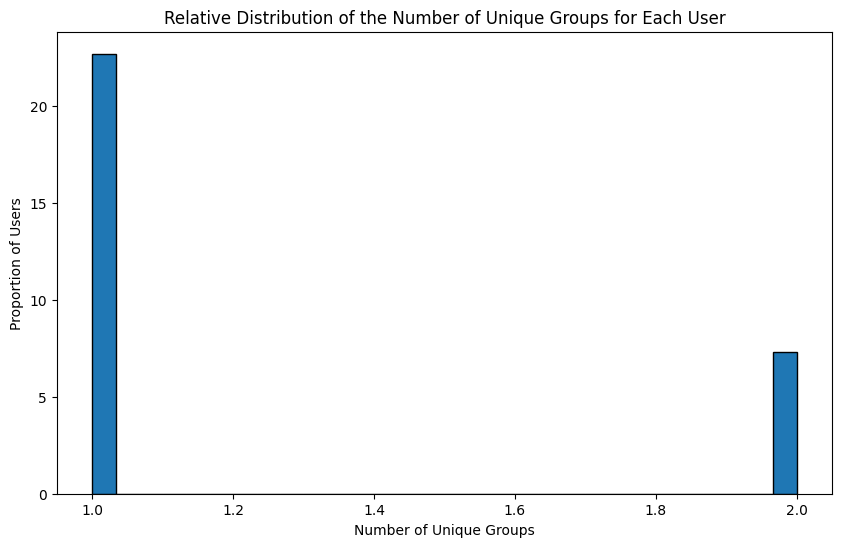

In [67]:
# Visualize the distribution of the number of unique groups per user in relative terms

plt.figure(figsize=(10,6))
plt.hist(unique_groups_per_user, bins=30, edgecolor='black', density=True)  # density=True pour normaliser
plt.title('Relative Distribution of the Number of Unique Groups for Each User')
plt.xlabel('Number of Unique Groups')
plt.ylabel('Proportion of Users')
plt.show()

In [136]:
# Calculate the percentage of users with 1 variant and 2 variants
percent_1_variant = (unique_groups_per_user[unique_groups_per_user == 1].count() / unique_groups_per_user.count()) * 100
percent_2_variants = (unique_groups_per_user[unique_groups_per_user == 2].count() / unique_groups_per_user.count()) * 100

# Display results
print(f"Percentage of users with 1 variant : {percent_1_variant:.2f}%")
print(f"Percentage of users with 2 variants : {percent_2_variants:.2f}%")

Percentage of users with 1 variant : 75.63%
Percentage of users with 2 variants : 24.37%


*What* can you observe ? Should we exclude these users ? Why ?

We see that there are such users and there are quite a lot of them - 24.37% approxiamatively. If we take these users into account, then the effect of changes in the experiment will be blurred. Therefore, we exclude user data from the calculation of changes in the experiment

In [ ]:
# TODO : users have 1 A/B test group ?

# TODO : Take only these users


In [137]:
# Identify users with exactly 1 variant
users_with_1_variant = unique_groups_per_user[unique_groups_per_user == 1].index

# Filter the data to keep only users with 1 variant
df_filtered = df[df['USER_ID'].isin(users_with_1_variant)]

# Verify result
print(f"Number of users with 1 A/B test group : {df_filtered['USER_ID'].nunique()}")

Number of users with 1 A/B test group : 4783


In [ ]:
# TODO : Leave only records with users with the 1st ab test group

# TODO : Check that the number of users matches what it was before the exception


In [138]:
df_filtered.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()

,count
VARIANT_NAME,
1,4783


In [139]:
# just in case, check that the number of users matches what it was before the exception
df_filtered.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts() == double_variant_count.iloc[0]

,count
VARIANT_NAME,
1,True


Let's see how the data is distributed

In [140]:
df_filtered.describe()

,USER_ID,REVENUE
count,6070.000000,6070.000000
mean,4983.664086,0.107064
std,2897.990118,2.673501
min,2.000000,0.000000
25%,2472.250000,0.000000
50%,4950.000000,0.000000
75%,7501.000000,0.000000
max,9998.000000,196.010000


In [ ]:
# TODO : Check how the data is distributed using a box plot


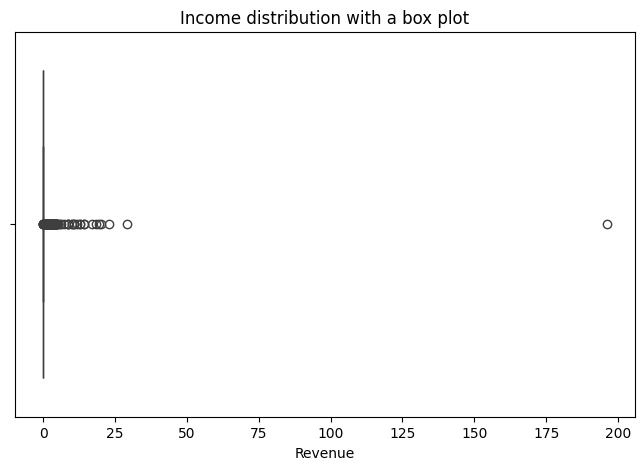

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a box plot to visualize revenue distribution
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_filtered['REVENUE'])

# Add a title
plt.title("Income distribution with a box plot")
plt.xlabel("Revenue")

# Box plot display
plt.show()

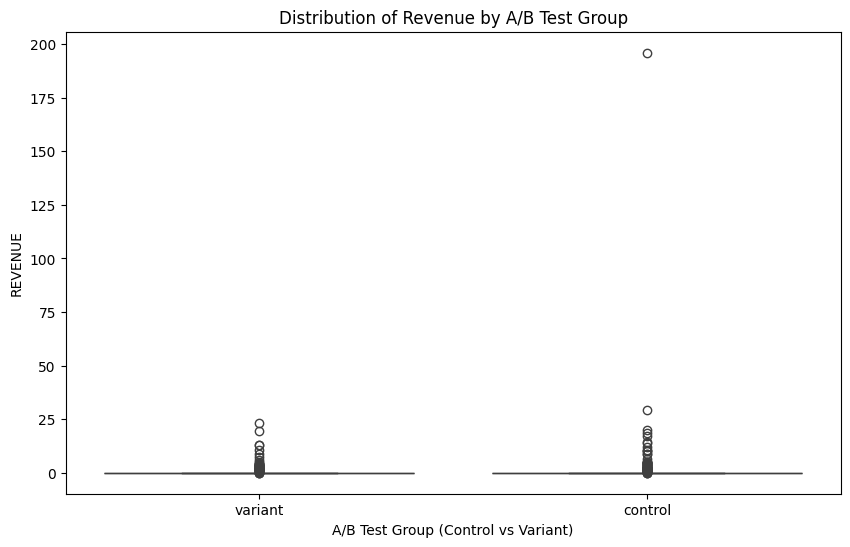

In [141]:
# Create a box plot for the variable 'revenue' based on the group 'variant_name'
plt.figure(figsize=(10, 6))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df_filtered)

# Add a title and labels for readability
plt.title('Distribution of Revenue by A/B Test Group')
plt.xlabel('A/B Test Group (Control vs Variant)')
plt.ylabel('REVENUE')

# Display the  plot
plt.show()

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [ ]:
# TODO : Sort these revenue values in descending order

In [142]:
# Sort 'income' values ​​in descending order
df_sorted = df_filtered.sort_values(by='REVENUE', ascending=False)

# Display the first 10 rows of the sorted DataFrame
print(df_sorted.head(10))

      USER_ID VARIANT_NAME  REVENUE
1437     3342      control   196.01
8168     2166      control    29.32
2482     7356      variant    23.04
6412     1053      control    20.07
5217     3684      variant    19.47
5530      282      control    18.56
758      4445      control    17.05
4031     2059      control    14.24
9019     1973      control    14.07
4561     4966      variant    12.99


In [ ]:
# TODO : See if user 3342 had other events with a strong outlier

In [143]:
import numpy as np

# Extract data from user 3342
user_3342_data = df_filtered[df_filtered['USER_ID'] == 3342]

# Calculate the mean and standard deviation of income
mean_revenue = df_filtered['REVENUE'].mean()
std_revenue = df_filtered['REVENUE'].std()

# Calculate the Z-score for this user

user_3342_data['z_score'] = (user_3342_data['REVENUE'] - mean_revenue) / std_revenue

# Select events considered outliers (Z-score > 3)
outliers_3342 = user_3342_data[user_3342_data['z_score'].abs() > 3]

# Display results
if not outliers_3342.empty:
    print("User 3342 has events with outliers :")
    print(outliers_3342[['USER_ID', 'REVENUE', 'z_score']])
else:
    print(" No outlier detected for user 3342.")

User 3342 has events with outliers :
      USER_ID  REVENUE    z_score
1437     3342   196.01  73.275818


<ipython-input-143-49a2ebde5707>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_3342_data['z_score'] = (user_3342_data['REVENUE'] - mean_revenue) / std_revenue


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

In [ ]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.

In [144]:
df_filtered = df_filtered[df_filtered['USER_ID'] != 3342]


*texte en italique*
What can you say about the users and their purchases ?

In [ ]:
# TODO : Check if there are users who have records with zero and positive revenue


In [145]:
(df_filtered.loc[
    (df_filtered['REVENUE'] == 0) & (df_filtered['USER_ID'].isin(df_filtered.loc[df['REVENUE'] > 0, 'USER_ID'].values)),
    'USER_ID'
]).count()

np.int64(52)

Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [ ]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user

In [146]:
df_filtered = df_filtered.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()


In [ ]:
# TODO : Visualize the resulting distribution of the data again.

([<matplotlib.axis.XTick at 0x7d9d7d3966d0>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

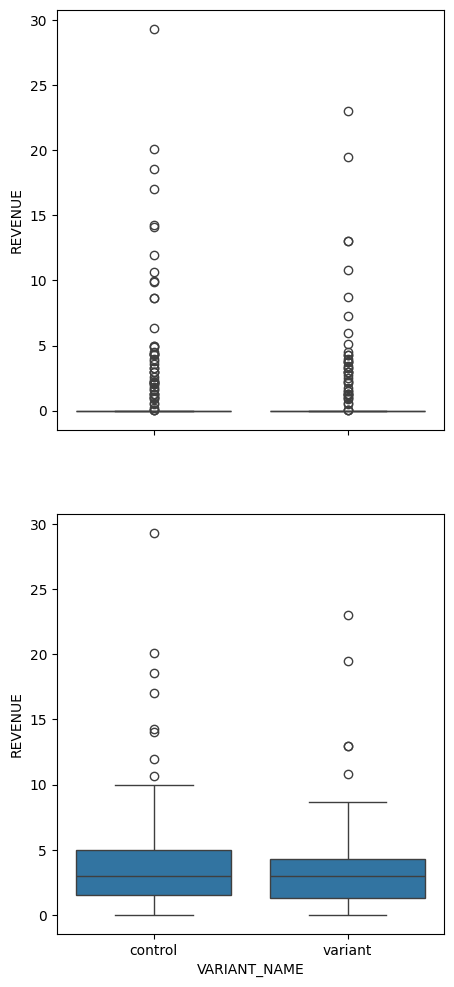

In [147]:
f, axes = plt.subplots(2, sharex=True, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df_filtered)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df_filtered[df_filtered['REVENUE'] > 0])
plt.xticks(np.arange(2), ('control', 'variant'))

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [ ]:
# TODO : get metrics by groups


# TODO : create two additional metrics to see relative changes


# TODO : add them to the rest of the metrics in a separate group


In [148]:
# Aggregation of statistics by variant
metric_stat = df_filtered.groupby(by='VARIANT_NAME').agg({
    'USER_ID': 'nunique',
    'REVENUE': ['sum', 'mean', 'median', 'count']
})

# Calculating relative metrics
orders_per_user = metric_stat[('REVENUE', 'count')] / metric_stat[('USER_ID', 'nunique')]
revenue_per_user = metric_stat[('REVENUE', 'sum')] / metric_stat[('USER_ID', 'nunique')]

# Adding new metrics to the DataFrame
metric_stat[('per_user', 'orders')] = orders_per_user
metric_stat[('per_user', 'revenue')] = revenue_per_user

# Display results
print(metric_stat)

             USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

We can  see that in the test group, the total amount of revenue and the average check per user decreased, but the number of orders per user slightly increased

In [ ]:
# TODO : get metrics by groups


# TODO : create two additional metrics to see relative changes


# TODO : add them to the rest of the metrics in a separate group


In [149]:
# Filter paying users (REVENUE != 0)
paid_users = df_filtered[df_filtered.REVENUE != 0]

# Group by VARIANT_NAME and calculate statistics
paid_stat = paid_users.groupby('VARIANT_NAME').agg(
    unique_users=('USER_ID', 'nunique'),
    total_revenue=('REVENUE', 'sum'),
    avg_revenue=('REVENUE', 'mean'),
    median_revenue=('REVENUE', 'median'),
    total_orders=('REVENUE', 'count')
)

# Add relative metrics
paid_stat['orders_per_user'] = paid_stat['total_orders'] / paid_stat['unique_users']
paid_stat['revenue_per_user'] = paid_stat['total_revenue'] / paid_stat['unique_users']

# Display results
print(paid_stat)

              unique_users  total_revenue  avg_revenue  median_revenue  \
VARIANT_NAME                                                             
control                 53         274.55     5.180189            2.99   
variant                 42         179.32     4.269524            2.97   

              total_orders  orders_per_user  revenue_per_user  
VARIANT_NAME                                                   
control                 53              1.0          5.180189  
variant                 42              1.0          4.269524  


Let's look at the distributions of all and only paying users

<ipython-input-150-6823f3e6b917>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
<ipython-input-150-6823f3e6b917>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'

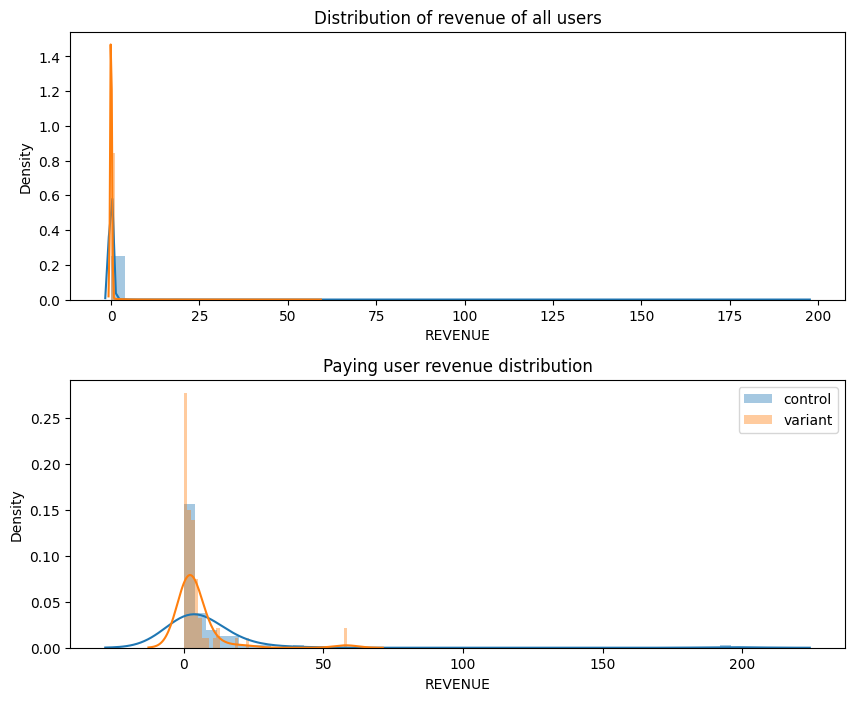

In [150]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [ ]:
# TODO : Use the Shapiro-Wilk criterion to confirm it

In [33]:
shapiro(df_filtered.loc[df_filtered.VARIANT_NAME == 'variant', 'REVENUE'])

ShapiroResult(statistic=np.float64(0.06145986897942335), pvalue=np.float64(9.962810723092505e-76))

P-value<0.05 so it's confirmed that data is not normally distributed.

The null hypothesis about the normal distribution of the data is rejected with p-value<0.05 .



Is the null hypothesis about the normal distribution of the data rejected ?

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [151]:
(df_filtered['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,4687
False,95


In [ ]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test

In [35]:
mannwhitneyu(df_filtered.loc[df_filtered.VARIANT_NAME == 'variant', 'REVENUE'], df_filtered.loc[df_filtered.VARIANT_NAME == 'control', 'REVENUE'])

MannwhitneyuResult(statistic=np.float64(2845109.0), pvalue=np.float64(0.24799555106821947))

In [ ]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test

In [36]:
mannwhitneyu(df_filtered.loc[(df_filtered.VARIANT_NAME == 'variant') & (df_filtered.REVENUE > 0), 'REVENUE'],
             df_filtered.loc[(df_filtered.VARIANT_NAME == 'control') & (df_filtered.REVENUE > 0), 'REVENUE'])

MannwhitneyuResult(statistic=np.float64(1029.0), pvalue=np.float64(0.5314192217084708))

#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [152]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
# TODO : Generate samples for all users

In [153]:
control = get_bootstrap_samples(df_filtered.loc[df_filtered.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df_filtered.loc[df_filtered.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

In [ ]:
# TODO : Generate samples for only paying users

In [154]:
control_paid = get_bootstrap_samples(df_filtered.loc[(df.VARIANT_NAME == 'control') & (df_filtered.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df_filtered.loc[(df.VARIANT_NAME == 'variant') & (df_filtered.REVENUE > 0), 'REVENUE'].values, 10000)

Let's look at the distribution of means in the ab test groups

<ipython-input-155-981be6013529>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
<ipython-input-155-981be6013529>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Sample mean distribution for all users')

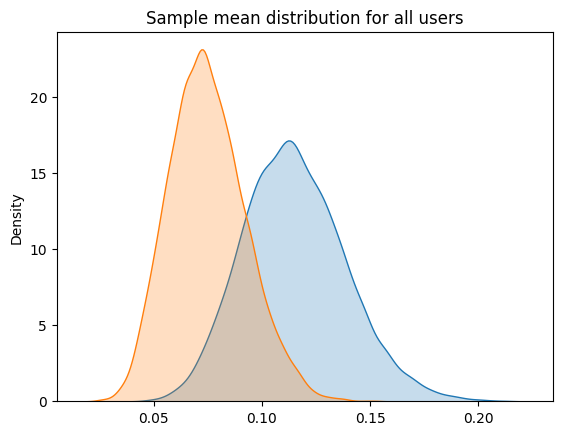

In [155]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

<ipython-input-156-fefa5149434d>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
<ipython-input-156-fefa5149434d>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Sample mean distribution for paying users')

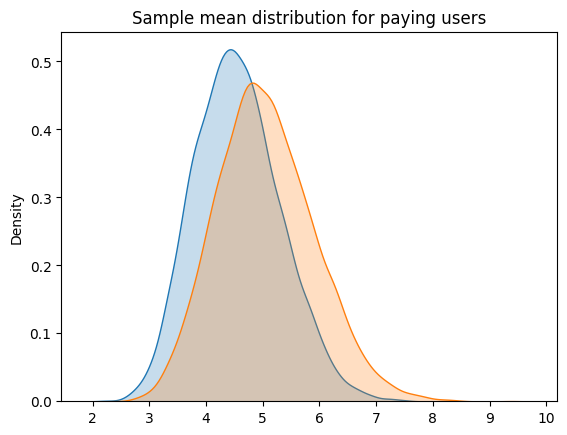

In [156]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

We see that there are differences, but the confidence intervals may overlap little bit so we need to look at the distribution of the difference in the means between the  2 groups to be able to draw final conclusions.



Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

In [157]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=False).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

<ipython-input-157-d0f6f944ed6d>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  points = sns.kdeplot(variant - control, shade=False).get_lines()[0].get_data()


array([-0.1003566 ,  0.01698374])

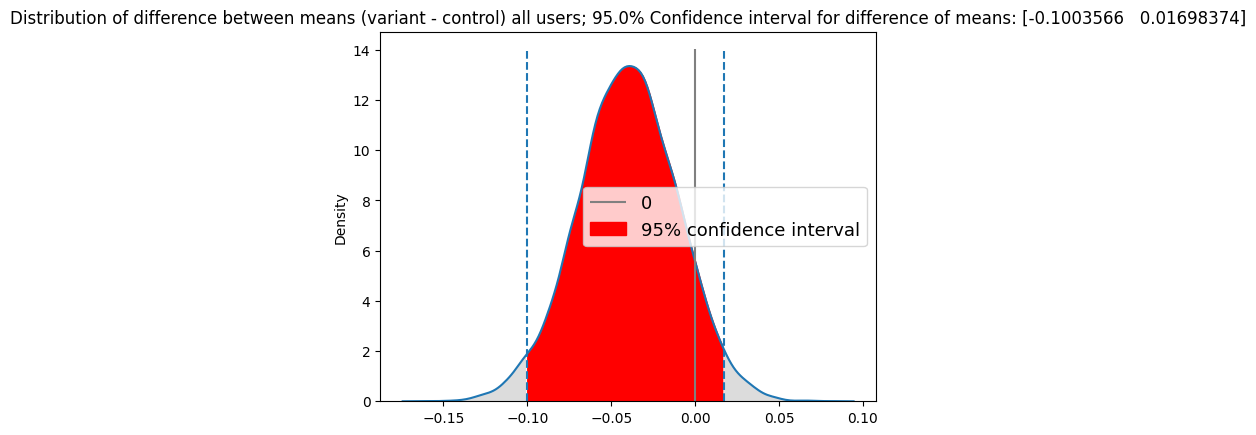

In [158]:
plot_distribution_and_stat_intervals(
    np.mean(variant, axis=1),
    np.mean(control, axis=1),
    title='all users'
)

<ipython-input-157-d0f6f944ed6d>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  points = sns.kdeplot(variant - control, shade=False).get_lines()[0].get_data()


array([-1.74544454,  2.76211483])

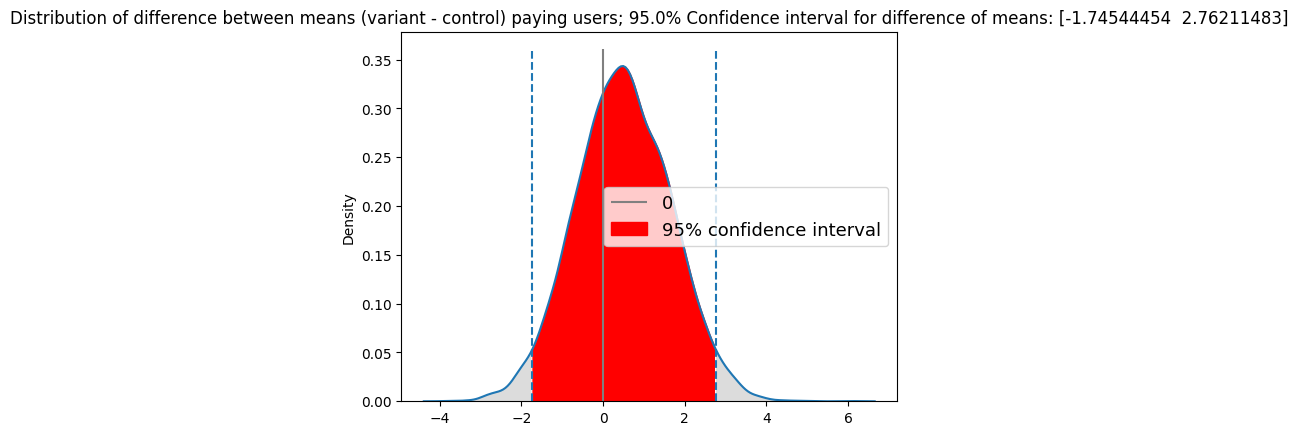

In [159]:
plot_distribution_and_stat_intervals(
    np.mean(variant_paid, axis=1),
    np.mean(control_paid, axis=1),
    title='paying users'
)

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.


We see that the zero value is within the confidence interval, so we cannot say about the statistical  significant change in average revenue between A/B test groups.